<a href="https://colab.research.google.com/github/2303a51863/NLP/blob/main/NLPPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pandas numpy matplotlib seaborn scikit-learn nltk spacy gensim wordcloud sentence-transformers transformers datasets joblib pytextrank umap-learn
!pip install --upgrade spacy typer wandb
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import os, re, math, time
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
import joblib
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
import spacy
import pytextrank # Import pytextrank here
nlp = spacy.load("en_core_web_sm")
if "textrank" not in nlp.pipe_names: # Add pytextrank pipe here
    nlp.add_pipe("textrank")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, FastText
from sentence_transformers import SentenceTransformer
DATA_PATH = "/content/mtsamples.csv"
assert os.path.exists(DATA_PATH), f"Upload mtsamples.csv to Colab and set DATA_PATH correctly. Tried: {DATA_PATH}"
df = pd.read_csv(DATA_PATH, encoding='latin-1', on_bad_lines='skip', engine='python')
print("Columns:", df.columns.tolist())
assert 'transcription' in df.columns, "Column 'transcription' not found. Check your file."
df = df[['transcription', 'medical_specialty']].dropna().reset_index(drop=True)
df['transcription'] = df['transcription'].astype(str)
print("Loaded rows:", len(df))
df.head(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/usr/local/lib/python3.12/dist-packages
Columns: ['Unnamed: 0', 'description', 'medical_specialty', 'sample_name', 'transcription', 'keywords']
Loaded rows: 1203


,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary
5,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...",Bariatrics
6,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...",Bariatrics
7,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",Cardiovascular / Pulmonary
8,"PREOPERATIVE DIAGNOSIS: , Lipodystrophy of the...",Bariatrics
9,"DESCRIPTION:,1. Normal cardiac chambers size....",Cardiovascular / Pulmonary


In [3]:
STOP = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def basic_clean(text):
    if text is None:
        return ""
    s = str(text).lower()
    s = re.sub(r'\[.*?\]', ' ', s)
    s = re.sub(r'\([^)]*\)', ' ', s)
    s = re.sub(r'[^a-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s
def tokenize_lemmatize(text):
    s = basic_clean(text)
    try:
        toks = word_tokenize(s)
    except:
        toks = s.split()
    toks = [t for t in toks if t not in STOP and len(t) > 1]
    toks = [lemmatizer.lemmatize(t) for t in toks]
    return toks
t0 = time.time()
df['clean'] = df['transcription'].apply(basic_clean)
df['tokens'] = df['clean'].apply(tokenize_lemmatize)
df['preproc_text'] = df['tokens'].apply(lambda toks: " ".join(toks))
print("Preprocessing done in {:.1f}s".format(time.time()-t0))
df[['transcription','preproc_text']].head()

Preprocessing done in 14.6s


,transcription,preproc_text
0,"SUBJECTIVE:, This 23-year-old white female pr...",subjective year old white female present compl...
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",past medical history difficulty climbing stair...
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",history present illness seen abc today pleasan...
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",mode left atrial enlargement left atrial diame...
4,1. The left ventricular cavity size and wall ...,left ventricular cavity size wall thickness ap...


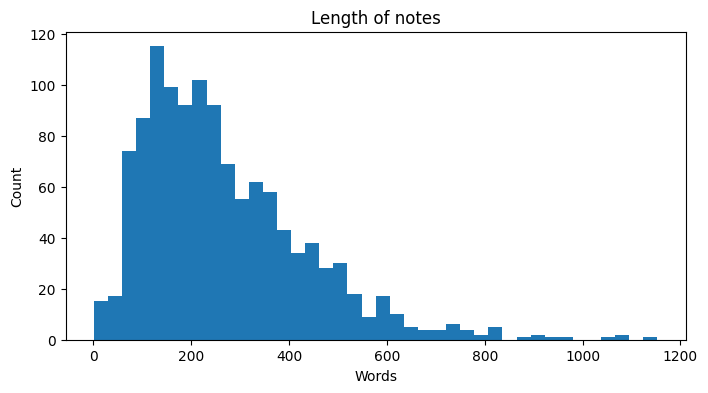

Top 20 words: [('patient', 5912), ('procedure', 3632), ('right', 3444), ('left', 3383), ('placed', 3138), ('using', 1864), ('incision', 1862), ('diagnosis', 1849), ('anesthesia', 1756), ('well', 1735), ('suture', 1665), ('removed', 1600), ('used', 1543), ('performed', 1510), ('skin', 1369), ('room', 1285), ('noted', 1195), ('taken', 1180), ('fashion', 1147), ('tissue', 1120)]


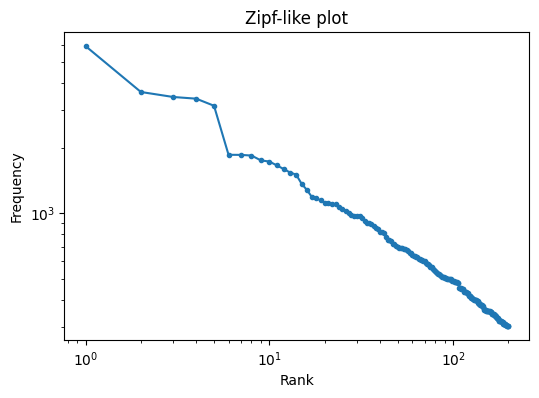

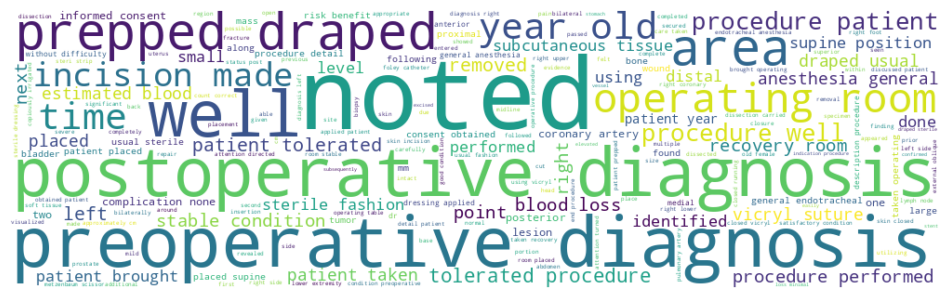

In [4]:
df['length'] = df['preproc_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4)); plt.hist(df['length'], bins=40); plt.title("Length of notes"); plt.xlabel("Words"); plt.ylabel("Count"); plt.show()
all_words = [w for toks in df['tokens'] for w in toks]
freq = Counter(all_words)
print("Top 20 words:", freq.most_common(20))
items = freq.most_common(200)
ranks = list(range(1,len(items)+1))
freqs = [c for _,c in items]
plt.figure(figsize=(6,4)); plt.loglog(ranks, freqs, marker='.'); plt.title("Zipf-like plot"); plt.xlabel("Rank"); plt.ylabel("Frequency"); plt.show()
from wordcloud import WordCloud
wc = WordCloud(width=1000, height=300, background_color='white').generate(" ".join(all_words))
plt.figure(figsize=(12,4)); plt.imshow(wc, interpolation='bilinear'); plt.axis('off'); plt.show()

In [5]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
df['sentences'] = df['transcription'].apply(lambda t: sent_tokenize(str(t)))
for i in range(2):
    print("Original:", df['transcription'].iloc[i][:250])
    print("Sentences:", df['sentences'].iloc[i][:5])
    print()

Original: SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time 
Sentences: ['SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.', 'She used to have allergies when she lived in Seattle but she thinks they are worse here.', 'In the past, she has tried Claritin, and Zyrtec.', 'Both worked for short time but then seemed to lose effectiveness.', 'She has used Allegra also.']

Original: PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor.  He exercises three times a week at home and does cardio.  He has difficulty walking two 
Sentences: ['PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating

# Bag-of-Words (BoW) & TF-IDF

In [7]:
MAX_FEAT = 5000
count_vect = CountVectorizer(max_features=MAX_FEAT, ngram_range=(1,2))
tfidf_vect = TfidfVectorizer(max_features=MAX_FEAT, ngram_range=(1,2))
X_counts = count_vect.fit_transform(df['preproc_text'])
X_tfidf = tfidf_vect.fit_transform(df['preproc_text'])
y = df['medical_specialty']
print("BoW shape:", X_counts.shape, "TF-IDF shape:", X_tfidf.shape)

BoW shape: (1203, 5000) TF-IDF shape: (1203, 5000)


# N-gram Language Model (bigram) + Laplace smoothing + Perplexity demo

In [8]:
from collections import defaultdict
token_lists = df['tokens'].tolist()
def build_bigram_counts(lists):
    bg_counts = defaultdict(int); ctx_counts = defaultdict(int)
    for toks in lists:
        seq = ['<s>'] + toks + ['</s>']
        for i in range(len(seq)-1):
            bg = (seq[i], seq[i+1])
            bg_counts[bg] += 1
            ctx_counts[(seq[i],)] += 1
    return bg_counts, ctx_counts
bigram_counts, context_counts = build_bigram_counts(token_lists)
vocab = set([w for toks in token_lists for w in toks])
V = len(vocab)
def laplace_prob(bg):
    ctx = (bg[0],)
    return (bigram_counts.get(bg,0) + 1) / (context_counts.get(ctx,0) + V)
def perplexity(tokens):
    seq = ['<s>'] + tokens + ['</s>']
    logp=0; N=0
    for i in range(len(seq)-1):
        p = laplace_prob((seq[i], seq[i+1]))
        logp += math.log(p)
        N += 1
    return math.exp(-logp/N)
print("Sample perplexity (first note):", perplexity(token_lists[0][:30]))

Sample perplexity (first note): 3473.540717054625


# POS Tagging & Chunking (shallow parsing)

In [9]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')   # NEW TAGGER
nltk.download('maxent_ne_chunker')
nltk.download('words')
sample = df['preproc_text'].iloc[0]
tokens = nltk.word_tokenize(sample)
pos_tags = nltk.pos_tag(tokens, tagset=None)
print("POS sample:", pos_tags[:30])
grammar = r"NP: {<DT>?<JJ>*<NN.*>+}"
cp = nltk.RegexpParser(grammar)
tree = cp.parse(pos_tags[:60])
print(tree)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


POS sample: [('subjective', 'JJ'), ('year', 'NN'), ('old', 'JJ'), ('white', 'JJ'), ('female', 'NN'), ('present', 'JJ'), ('complaint', 'NN'), ('allergy', 'NN'), ('used', 'VBN'), ('allergy', 'RB'), ('lived', 'VBD'), ('seattle', 'JJ'), ('think', 'NN'), ('worse', 'JJR'), ('past', 'NN'), ('tried', 'VBD'), ('claritin', 'NN'), ('zyrtec', 'NN'), ('worked', 'VBD'), ('short', 'JJ'), ('time', 'NN'), ('seemed', 'VBD'), ('lose', 'JJ'), ('effectiveness', 'NN'), ('used', 'VBN'), ('allegra', 'NN'), ('also', 'RB'), ('used', 'VBD'), ('last', 'JJ'), ('summer', 'NN')]
(S
  (NP subjective/JJ year/NN)
  (NP old/JJ white/JJ female/NN)
  (NP present/JJ complaint/NN allergy/NN)
  used/VBN
  allergy/RB
  lived/VBD
  (NP seattle/JJ think/NN)
  worse/JJR
  (NP past/NN)
  tried/VBD
  (NP claritin/NN zyrtec/NN)
  worked/VBD
  (NP short/JJ time/NN)
  seemed/VBD
  (NP lose/JJ effectiveness/NN)
  used/VBN
  (NP allegra/NN)
  also/RB
  used/VBD
  (NP last/JJ summer/NN)
  began/VBD
  using/VBG
  two/CD
  (NP week/NN)
  

#Named Entity Recognition (NER) using spaCy

In [10]:
try:
    nlp_clin = spacy.load("en_core_sci_sm")
    print("Using scispaCy en_core_sci_sm")
except Exception:
    nlp_clin = spacy.load("en_core_web_sm")
    print("Using spaCy en_core_web_sm (general NER)")
doc = nlp_clin(df['transcription'].iloc[0])
print("Entities sample:", [(ent.text, ent.label_) for ent in doc.ents][:40])

Using spaCy en_core_web_sm (general NER)
Entities sample: [('23-year-old', 'DATE'), ('Seattle', 'GPE'), ('Claritin', 'PERSON'), ('Zyrtec', 'LANGUAGE'), ('Allegra', 'ORG'), ('last summer', 'DATE'), ('two weeks ago', 'DATE'), ('daily', 'DATE'), ('Ortho Tri-Cyclen', 'PERSON'), ('Allegra', 'ORG'), ('130 pounds', 'QUANTITY'), ('Nasal', 'ORG'), ('Allergic', 'ORG'), ('Zyrtec', 'NORP'), ('Allegra', 'ORG'), ('Samples of Nasonex', 'ORG'), ('two', 'CARDINAL'), ('three weeks', 'DATE')]


# Topic Modeling (LDA)

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
X_counts_for_lda = count_vect.fit_transform(df['preproc_text'])
n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda.fit(X_counts_for_lda)
def show_topics(model, feature_names, n_top=12):
    for i, topic in enumerate(model.components_):
        top = [feature_names[j] for j in topic.argsort()[-n_top:][::-1]]
        print("Topic %d:"%(i+1), ", ".join(top))
show_topics(lda, count_vect.get_feature_names_out(), 12)

Topic 1: patient, procedure, placed, normal, using, diagnosis, well, incision, right, removed, noted, bladder
Topic 2: left, right, artery, patient, coronary, catheter, procedure, eye, pressure, coronary artery, anterior, pulmonary
Topic 3: patient, procedure, right, left, placed, suture, diagnosis, incision, skin, closed, used, anesthesia
Topic 4: patient, placed, procedure, left, right, suture, incision, using, anesthesia, skin, diagnosis, well
Topic 5: patient, right, placed, left, procedure, well, incision, used, foot, knee, medial, anesthesia
Topic 6: patient, bladder, procedure, placed, removed, room, diagnosis, anesthesia, right, artery, noted, french


# Text Similarity: Cosine, Jaccard, WordNet

In [12]:
print("Cosine sim (doc0,doc1):", cosine_similarity(X_tfidf[0], X_tfidf[1])[0][0])
def jaccard(a,b):
    A=set(a); B=set(b)
    return len(A&B)/len(A|B) if len(A|B)>0 else 0
print("Jaccard sample:", jaccard(df['tokens'].iloc[0], df['tokens'].iloc[1]))
from nltk.corpus import wordnet as wn
def wn_sim(w1,w2):
    s1=wn.synsets(w1); s2=wn.synsets(w2)
    if not s1 or not s2: return None
    return max((a.path_similarity(b) or 0) for a in s1 for b in s2)
print("WordNet sim (heart, cardiac):", wn_sim('heart','cardiac'))

Cosine sim (doc0,doc1): 0.14831417285117288
Jaccard sample: 0.07142857142857142
WordNet sim (heart, cardiac): 0.125


# Word Embeddings: Word2Vec & FastText

In [13]:
sentences = df['tokens'].tolist()
w2v = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4, seed=42)
print("W2V vocab size:", len(w2v.wv.index_to_key))
if 'pain' in w2v.wv:
    print("Most similar to 'pain':", w2v.wv.most_similar('pain', topn=8))
ft = FastText(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4, seed=42)
print("FastText trained.")

W2V vocab size: 8510
Most similar to 'pain': [('intractable', 0.8910459876060486), ('post', 0.8909733891487122), ('genital', 0.8753314018249512), ('itching', 0.8675296306610107), ('cramping', 0.8628084659576416), ('preop', 0.8616744875907898), ('acoustic', 0.8613662719726562), ('vasectomy', 0.860402524471283)]
FastText trained.


## Sentence Embeddings (SBERT)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/38 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


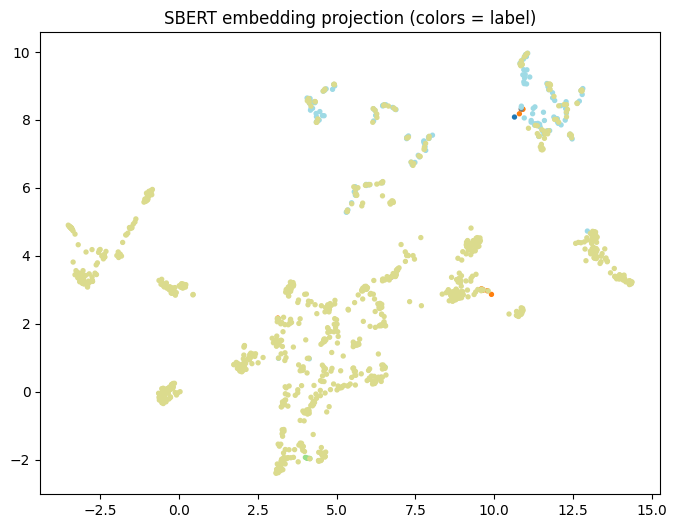

In [14]:
sbert = SentenceTransformer('all-MiniLM-L6-v2')
docs = df['transcription'].tolist()
embs = sbert.encode(docs, show_progress_bar=True, batch_size=32)
try:
    import umap
    proj = umap.UMAP(n_components=2, random_state=42).fit_transform(embs)
except:
    from sklearn.manifold import TSNE
    proj = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(embs[:1000]) if len(embs)>1000 else TSNE(n_components=2, random_state=42).fit_transform(embs)
plt.figure(figsize=(8,6))
labels = df['medical_specialty'].astype('category').cat.codes
plt.scatter(proj[:,0], proj[:,1], c=labels, s=8, cmap='tab20')
plt.title("SBERT embedding projection (colors = label)"); plt.show()

# Classification: TF-IDF + Logistic Regression & Naive Bayes (evaluation)

In [15]:
specialty_counts = df['medical_specialty'].value_counts()
single_instance_specialties = specialty_counts[specialty_counts == 1].index

if len(single_instance_specialties) > 0:
    print(f"Removing {len(single_instance_specialties)} medical specialties with only one sample: {list(single_instance_specialties)}")
    df = df[~df['medical_specialty'].isin(single_instance_specialties)].copy()
    df.reset_index(drop=True, inplace=True)
    print(f"New number of rows after filtering: {len(df)}")
else:
    print("No medical specialties with only one sample found. Proceeding with original DataFrame.")
count_vect = CountVectorizer(max_features=MAX_FEAT, ngram_range=(1,2))
tfidf_vect = TfidfVectorizer(max_features=MAX_FEAT, ngram_range=(1,2))

X_counts = count_vect.fit_transform(df['preproc_text'])
X_tfidf = tfidf_vect.fit_transform(df['preproc_text'])
y = df['medical_specialty']

print("BoW shape after filtering:", X_counts.shape, "TF-IDF shape after filtering:", X_tfidf.shape)
print("Updated number of unique specialties:", y.nunique())

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)
lr = LogisticRegression(max_iter=3000, class_weight='balanced')
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print("LogReg Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr, zero_division=0))
nb = MultinomialNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)
print("NB Accuracy:", accuracy_score(y_test, pred_nb))
print(classification_report(y_test, pred_nb, zero_division=0))

Removing 4 medical specialties with only one sample: [' Neurology', ' Allergy / Immunology', ' Dentistry', ' General Medicine']
New number of rows after filtering: 1199
BoW shape after filtering: (1199, 5000) TF-IDF shape after filtering: (1199, 5000)
Updated number of unique specialties: 4
LogReg Accuracy: 0.8541666666666666
                             precision    recall  f1-score   support

                 Bariatrics       0.00      0.00      0.00         2
 Cardiovascular / Pulmonary       0.00      0.00      0.00         1
                    Surgery       0.94      0.89      0.92       206
                    Urology       0.50      0.71      0.59        31

                   accuracy                           0.85       240
                  macro avg       0.36      0.40      0.38       240
               weighted avg       0.87      0.85      0.86       240

NB Accuracy: 0.875
                             precision    recall  f1-score   support

                 Bariatrics 

# K-Fold Cross-Validation (10-fold)

In [21]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 10-fold cross validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    lr,        # logistic regression model from Cell 13
    X_tfidf,
    df['medical_specialty'],
    cv=kf,
    scoring='accuracy'
)

print("10-Fold CV Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Std Dev:", cv_scores.std())

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


10-Fold CV Accuracy Scores: [0.88333333 0.9        0.9        0.83333333 0.875      0.86666667
 0.85       0.85833333 0.91666667 0.87394958]
Mean CV Accuracy: 0.8757282913165266
Std Dev: 0.023999350384960608


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Macro Precision :", precision_score(y_test, pred_lr, average='macro', zero_division=0))
print("Macro Recall    :", recall_score(y_test, pred_lr, average='macro', zero_division=0))
print("Macro F1 Score  :", f1_score(y_test, pred_lr, average='macro', zero_division=0))

print("\nWeighted Precision :", precision_score(y_test, pred_lr, average='weighted', zero_division=0))
print("Weighted Recall    :", recall_score(y_test, pred_lr, average='weighted', zero_division=0))
print("Weighted F1 Score  :", f1_score(y_test, pred_lr, average='weighted', zero_division=0))


Macro Precision : 0.36082474226804123
Macro Recall    : 0.3995067334794864
Macro F1 Score  : 0.3754166666666667

Weighted Precision : 0.8742482817869416
Weighted Recall    : 0.8541666666666666
Weighted F1 Score  : 0.8611527777777778


In [23]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
labels = lr.classes_
y_test_bin = label_binarize(y_test, classes=labels)
y_proba = lr.predict_proba(X_test)
auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print("Macro AUC (OvR):", auc)

Macro AUC (OvR): 0.9332084467219471


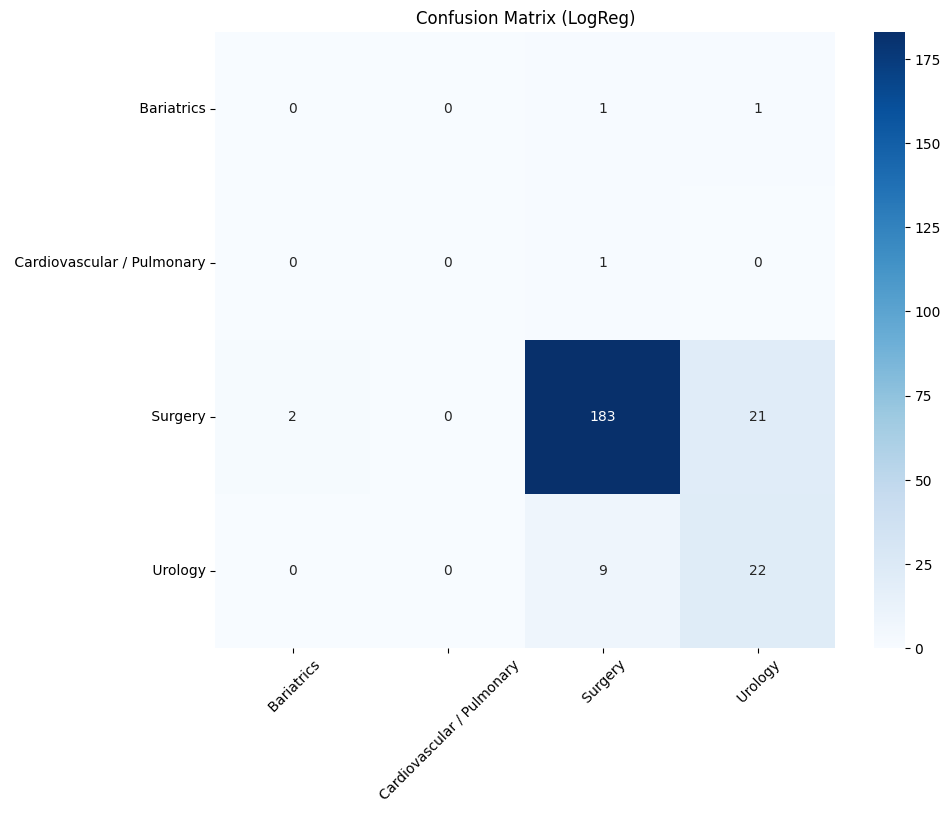

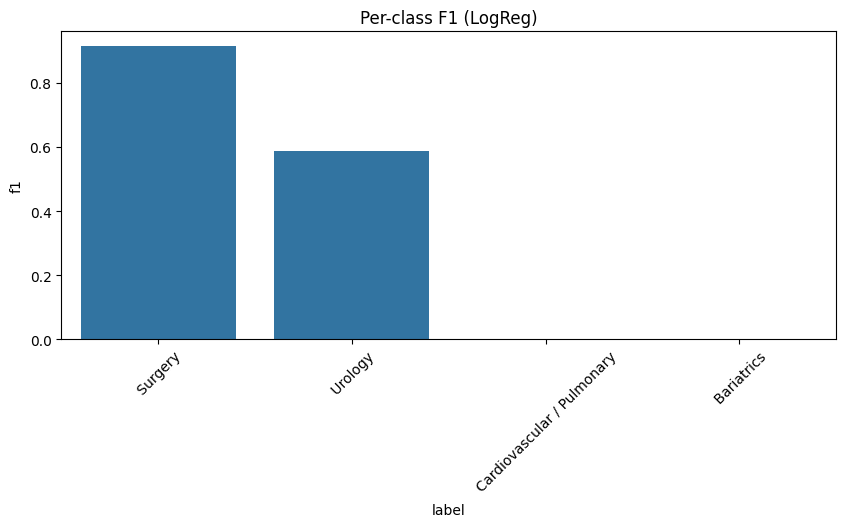

In [24]:
import seaborn as sns
cm = confusion_matrix(y_test, pred_lr, labels=lr.classes_)
plt.figure(figsize=(10,8)); sns.heatmap(cm, annot=True, fmt='d', xticklabels=lr.classes_, yticklabels=lr.classes_, cmap='Blues'); plt.xticks(rotation=45); plt.yticks(rotation=0); plt.title("Confusion Matrix (LogReg)"); plt.show()
from sklearn.metrics import precision_recall_fscore_support
p,r,f,_ = precision_recall_fscore_support(y_test, pred_lr, labels=lr.classes_, zero_division=0)
f1_df = pd.DataFrame({'label':lr.classes_, 'f1':f}).sort_values('f1', ascending=False)
plt.figure(figsize=(10,4)); sns.barplot(x='label', y='f1', data=f1_df); plt.xticks(rotation=45); plt.title("Per-class F1 (LogReg)"); plt.show()

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize
import numpy as np

def tfidf_summarize(text, n_sent=2):
    if not isinstance(text, str) or not text.strip():
        return ""

    sentences = sent_tokenize(text)
    if len(sentences) <= n_sent:
        return " ".join(sentences)
    vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
    try:
        tfidf_matrix = vectorizer.fit_transform(sentences)
    except ValueError:
        return " ".join(sentences[:n_sent])
    sentence_scores = np.asarray(tfidf_matrix.sum(axis=1)).flatten()

    top_sentence_indices = sentence_scores.argsort()[-n_sent:]

    top_sentence_indices = np.sort(top_sentence_indices)

    summary_sentences = [sentences[i] for i in top_sentence_indices]
    return " ".join(summary_sentences)

print("Summary (TF-IDF):", tfidf_summarize(df['transcription'].iloc[0], n_sent=2))

Summary (TF-IDF): Denies obesity and hypertension in other family members.,CURRENT MEDICATIONS:, None.,ALLERGIES:,  He is allergic to Penicillin.,MISCELLANEOUS/EATING HISTORY:, He has been going to support groups for seven months with Lynn Holmberg in Greenwich and he is from Eastchester, New York and he feels that we are the appropriate program. Specifically denies chest pain, heart attack, coronary artery disease, congestive heart failure, arrhythmia, atrial fibrillation, pacemaker, high cholesterol, pulmonary embolism, high blood pressure, CVA, venous insufficiency, thrombophlebitis, asthma, shortness of breath, COPD, emphysema, sleep apnea, diabetes, leg and foot swelling, osteoarthritis, rheumatoid arthritis, hiatal hernia, peptic ulcer disease, gallstones, infected gallbladder, pancreatitis, fatty liver, hepatitis, hemorrhoids, rectal bleeding, polyps, incontinence of stool, urinary stress incontinence, or cancer.


# BERT fine-tuning

In [45]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np

small = df[['preproc_text','medical_specialty']].rename(columns={'preproc_text':'text','medical_specialty':'label'}).copy()
label2id = {l:i for i,l in enumerate(small['label'].unique())}
small['label_id'] = small['label'].map(label2id)
ds = Dataset.from_pandas(small[['text','label_id']])
ds = ds.train_test_split(test_size=0.15, seed=42)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize_fn(batch): return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)
ds = ds.map(tokenize_fn, batched=True)
ds = ds.rename_column("label_id","labels"); ds.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label2id))
# Add report_to="none" to explicitly disable wandb logging
training_args = TrainingArguments(output_dir="./bert_out", num_train_epochs=2, per_device_train_batch_size=8, eval_strategy="epoch", save_strategy="epoch", learning_rate=2e-5, report_to="none")
from sklearn.metrics import f1_score, accuracy_score
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1); labels = p.label_ids
    return {"accuracy": float(accuracy_score(labels,preds)), "f1_macro": float(f1_score(labels,preds, average='macro'))}

trainer = Trainer(model=model, args=training_args, train_dataset=ds['train'], eval_dataset=ds['test'], compute_metrics=compute_metrics)

Map:   0%|          | 0/1019 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
import os
import joblib

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

joblib.dump(lr, 'models/logreg_tfidf.pkl')
joblib.dump(nb, 'models/nb_tfidf.pkl')
joblib.dump(tfidf_vect, 'models/tfidf_vectorizer.pkl')
w2v.save('models/word2vec.model')
ft.save('models/fasttext.model')
print("Saved baseline models & embeddings in ./models")

Saved baseline models & embeddings in ./models


In [47]:
import os
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.399327,0.822222,0.461474
2,No log,0.321771,0.816667,0.467508


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=256, training_loss=0.3831281065940857, metrics={'train_runtime': 2690.4144, 'train_samples_per_second': 0.758, 'train_steps_per_second': 0.095, 'total_flos': 134583721519104.0, 'train_loss': 0.3831281065940857, 'epoch': 2.0})

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
bert_eval_results = trainer.evaluate()
bert_accuracy = bert_eval_results['eval_accuracy']
bert_f1_macro = bert_eval_results['eval_f1_macro']

bert_predictions = trainer.predict(ds['test'])
bert_preds = np.argmax(bert_predictions.predictions, axis=1)
bert_labels = bert_predictions.label_ids

bert_macro_precision = precision_score(bert_labels, bert_preds, average='macro', zero_division=0)
bert_macro_recall = recall_score(bert_labels, bert_preds, average='macro', zero_division=0)
metrics_data = {
    'Model': ['Logistic Regression', 'Naive Bayes', 'BERT'],
    'Accuracy': [
        accuracy_score(y_test, pred_lr),
        accuracy_score(y_test, pred_nb),
        bert_accuracy
    ],
    'Macro Precision': [
        precision_score(y_test, pred_lr, average='macro', zero_division=0),
        precision_score(y_test, pred_nb, average='macro', zero_division=0),
        bert_macro_precision
    ],
    'Macro Recall': [
        recall_score(y_test, pred_lr, average='macro', zero_division=0),
        recall_score(y_test, pred_nb, average='macro', zero_division=0),
        bert_macro_recall
    ],
    'Macro F1-Score': [
        f1_score(y_test, pred_lr, average='macro', zero_division=0),
        f1_score(y_test, pred_nb, average='macro', zero_division=0),
        bert_f1_macro
    ]
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                 Model  Accuracy  Macro Precision  Macro Recall  \
0  Logistic Regression  0.854167         0.360825      0.399507   
1          Naive Bayes  0.875000         0.407328      0.295960   
2                 BERT  0.816667         0.460755      0.475588   

   Macro F1-Score  
0        0.375417  
1        0.309800  
2        0.467508  


/tmp/ipython-input-1568685088.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')


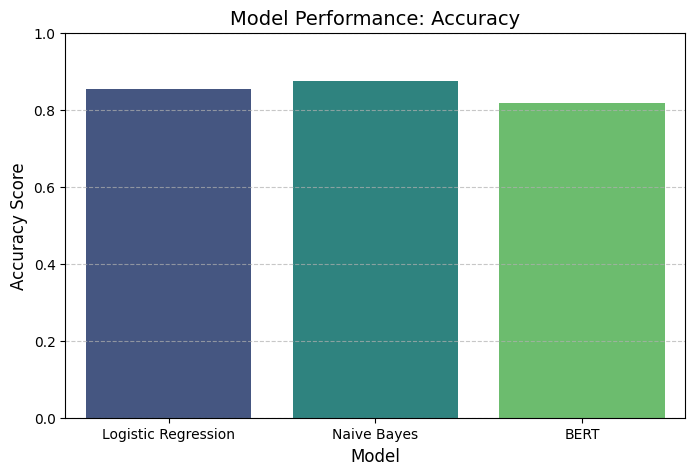

/tmp/ipython-input-1568685088.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')


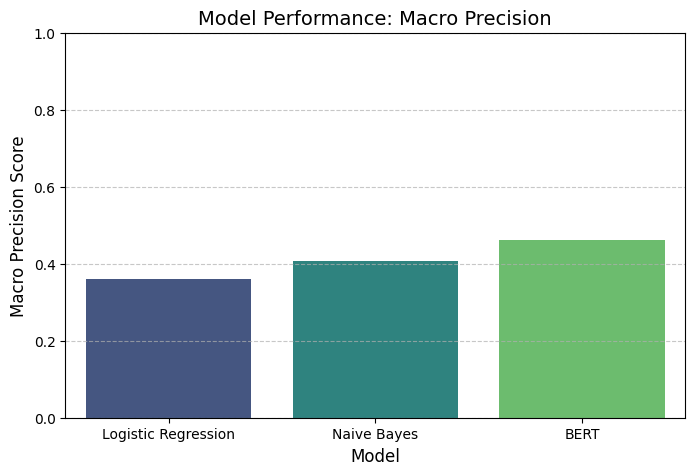

/tmp/ipython-input-1568685088.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')


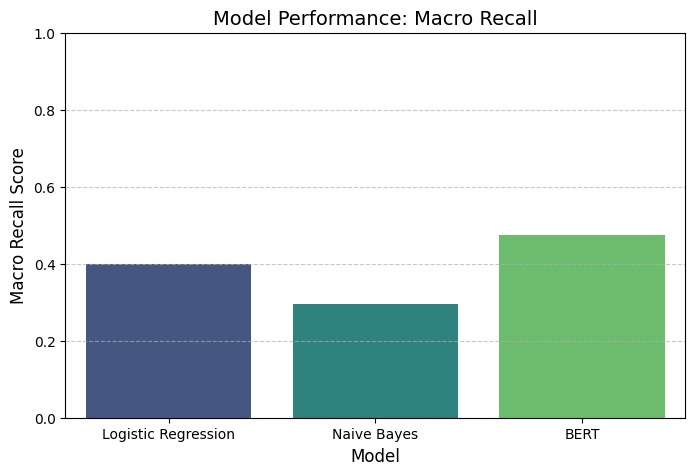

/tmp/ipython-input-1568685088.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')


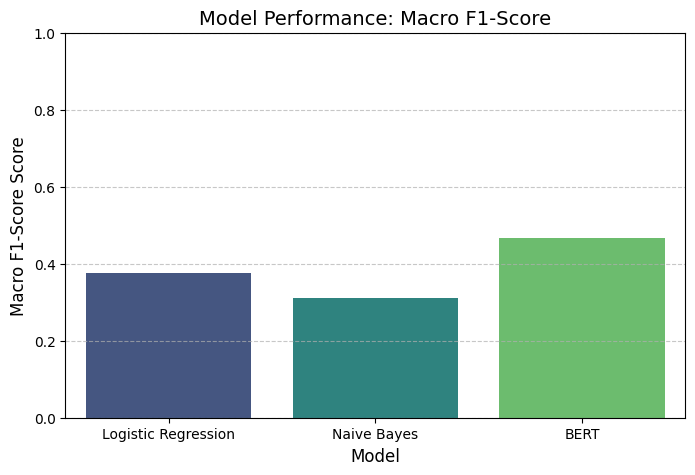

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_to_plot = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score']

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
    plt.title(f'Model Performance: {metric}', fontsize=14)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel(f'{metric} Score', fontsize=12)
    plt.ylim(0, 1) # Metrics are typically between 0 and 1
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


Generating Confusion Matrix for Logistic Regression...


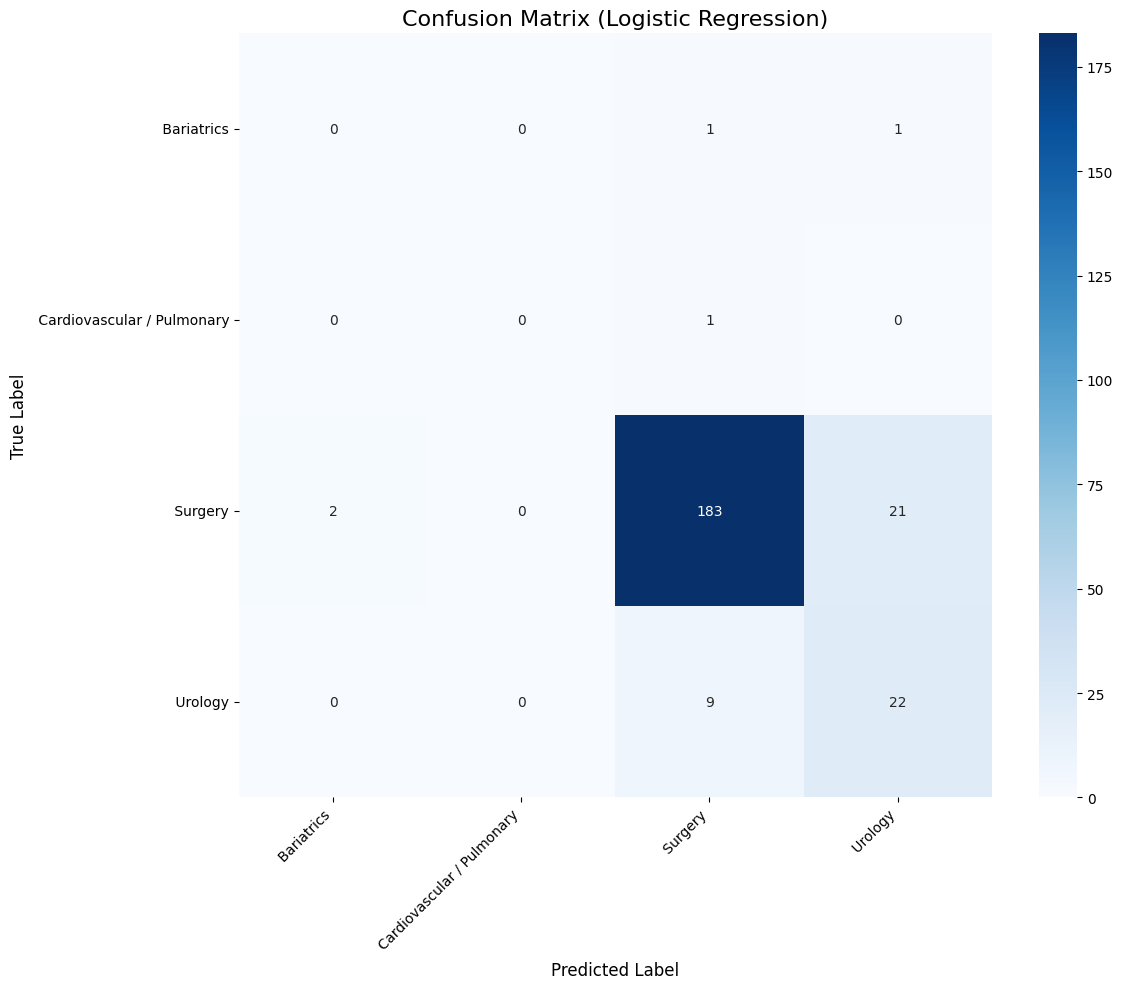

Generating Confusion Matrix for Naive Bayes...


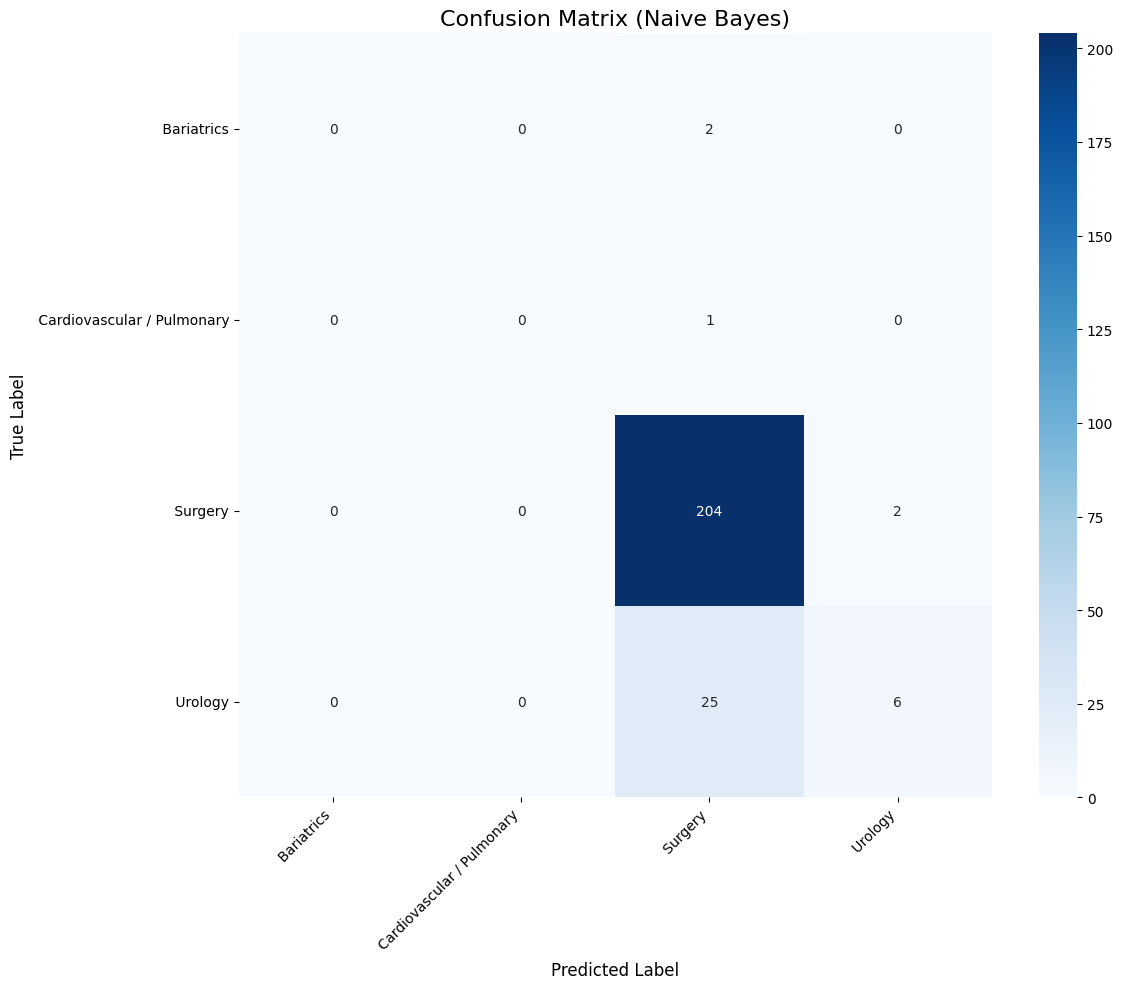

Generating Confusion Matrix for BERT...


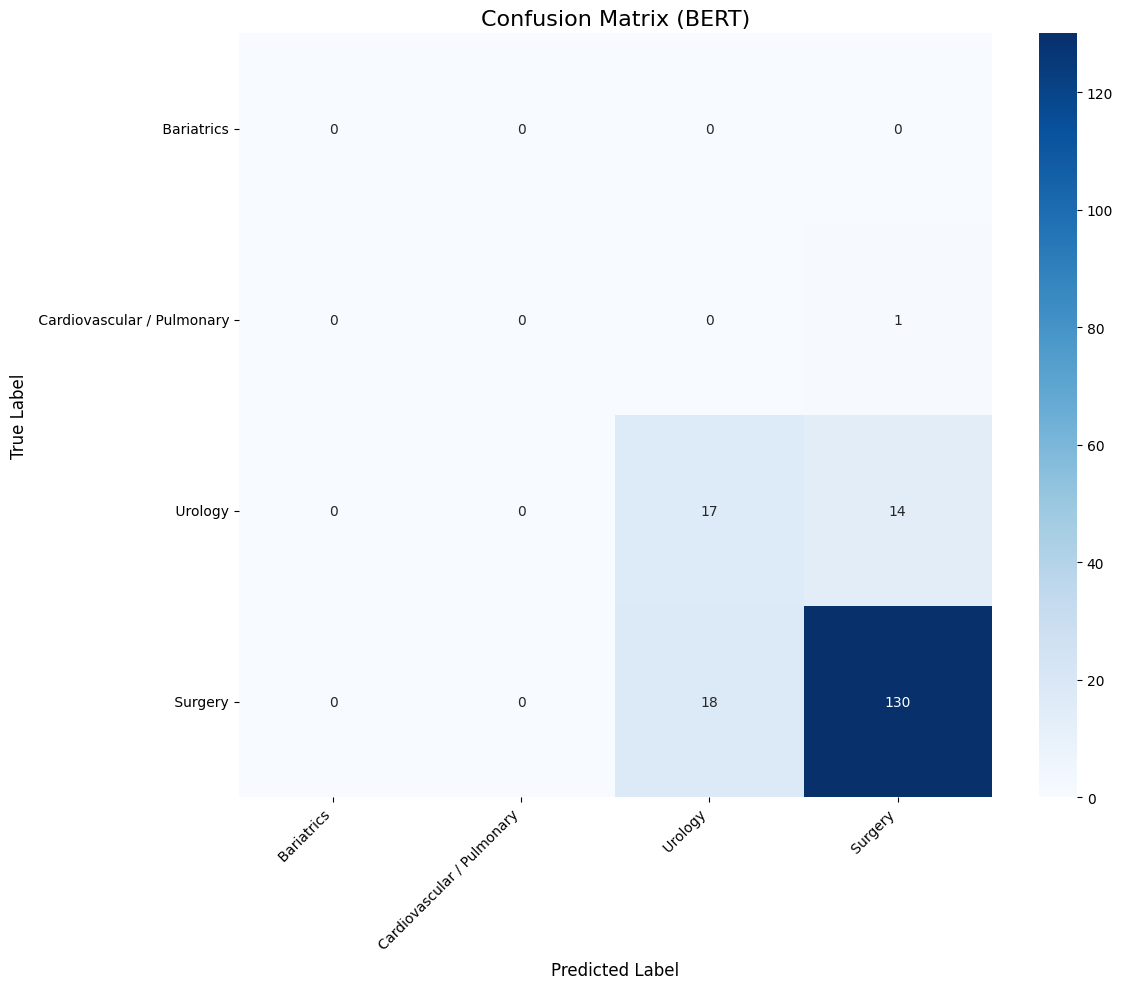

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("Generating Confusion Matrix for Logistic Regression...")
cm_lr = confusion_matrix(y_test, pred_lr, labels=lr.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=lr.classes_, yticklabels=lr.classes_, cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Confusion Matrix (Logistic Regression)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

print("Generating Confusion Matrix for Naive Bayes...")
cm_nb = confusion_matrix(y_test, pred_nb, labels=nb.classes_)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_nb, annot=True, fmt='d', xticklabels=nb.classes_, yticklabels=nb.classes_, cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Confusion Matrix (Naive Bayes)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

print("Generating Confusion Matrix for BERT...")
id2label = {i: l for l, i in label2id.items()}
bert_class_labels = [id2label[i] for i in sorted(id2label.keys())]

cm_bert = confusion_matrix(bert_labels, bert_preds, labels=sorted(id2label.keys()))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_bert, annot=True, fmt='d', xticklabels=bert_class_labels, yticklabels=bert_class_labels, cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Confusion Matrix (BERT)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_WORDS = 5000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<unk>')

tokenizer.fit_on_texts(df['preproc_text'])

sequences = tokenizer.texts_to_sequences(df['preproc_text'])

padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print("Shape of padded sequences:", padded_sequences.shape)
print("Example of a padded sequence:", padded_sequences[0])
print("Vocabulary size (including OOV token):", len(tokenizer.word_index) + 1)


Shape of padded sequences: (1199, 100)
Example of a padded sequence: [ 471  522   49  188    1    1  188    1    1 2176 1694   14    1    1
 2560 3540  819 2668  283   35  269  554    1  188 3360   69  285  979
    1    1  188 4738  103  173   74  262  170   74   82   74  160  447
   74  990 1590 1114  151  471  127   49 2669 4333   83    4  597   48
  690 2052   49 1737  561 3032 2306   48    1 1312  454  448  690 3202
  414  283    1  252  514   49  311  151    1 3783 2177 3783 1549  833
 1954 1313  514 4334 1267  344   97 1150 2768 3541    1 3203   49  614
 1418 2900]
Vocabulary size (including OOV token): 11638


LSTM

In [54]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['medical_specialty'])

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    padded_sequences, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of X_test_lstm:", X_test_lstm.shape)
print("Shape of y_train_lstm:", y_train_lstm.shape)
print("Shape of y_test_lstm:", y_test_lstm.shape)

Shape of X_train_lstm: (959, 100)
Shape of X_test_lstm: (240, 100)
Shape of y_train_lstm: (959,)
Shape of y_test_lstm: (240,)


In [55]:
import tensorflow as tf
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Model compiled successfully.")
history = model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm)
)
print("Model training completed.")

Model compiled successfully.
Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.7706 - loss: 0.9995 - val_accuracy: 0.8583 - val_loss: 0.4616
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.8437 - loss: 0.4880 - val_accuracy: 0.8583 - val_loss: 0.4525
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 312ms/step - accuracy: 0.8437 - loss: 0.4564 - val_accuracy: 0.8625 - val_loss: 0.4272
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 288ms/step - accuracy: 0.8467 - loss: 0.3469 - val_accuracy: 0.8042 - val_loss: 0.4411
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 286ms/step - accuracy: 0.9055 - loss: 0.2654 - val_accuracy: 0.8000 - val_loss: 0.4806
Model training completed.


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predictions_proba_lstm = model.predict(X_test_lstm)

predictions_labels_lstm = np.argmax(predictions_proba_lstm, axis=1)

accuracy_lstm = accuracy_score(y_test_lstm, predictions_labels_lstm)
macro_precision_lstm = precision_score(y_test_lstm, predictions_labels_lstm, average='macro', zero_division=0)
macro_recall_lstm = recall_score(y_test_lstm, predictions_labels_lstm, average='macro', zero_division=0)
macro_f1_lstm = f1_score(y_test_lstm, predictions_labels_lstm, average='macro', zero_division=0)

print(f"LSTM Model Accuracy: {accuracy_lstm:.4f}")
print(f"LSTM Model Macro Precision: {macro_precision_lstm:.4f}")
print(f"LSTM Model Macro Recall: {macro_recall_lstm:.4f}")
print(f"LSTM Model Macro F1-score: {macro_f1_lstm:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
LSTM Model Accuracy: 0.8000
LSTM Model Macro Precision: 0.2523
LSTM Model Macro Recall: 0.2536
LSTM Model Macro F1-score: 0.2512


In [57]:
from sklearn.metrics import classification_report
print("\nLSTM Model Classification Report:")
print(classification_report(y_test_lstm, predictions_labels_lstm, target_names=label_encoder.classes_, zero_division=0))



LSTM Model Classification Report:
                             precision    recall  f1-score   support

                 Bariatrics       0.00      0.00      0.00         2
 Cardiovascular / Pulmonary       0.00      0.00      0.00         1
                    Surgery       0.86      0.92      0.89       206
                    Urology       0.15      0.10      0.12        31

                   accuracy                           0.80       240
                  macro avg       0.25      0.25      0.25       240
               weighted avg       0.76      0.80      0.78       240



In [58]:
lstm_metrics = {
    'Model': 'LSTM',
    'Accuracy': accuracy_lstm,
    'Macro Precision': macro_precision_lstm,
    'Macro Recall': macro_recall_lstm,
    'Macro F1-Score': macro_f1_lstm
}

metrics_df = pd.concat([metrics_df, pd.DataFrame([lstm_metrics])], ignore_index=True)

print("Updated metrics DataFrame:")
print(metrics_df)

Updated metrics DataFrame:
                 Model  Accuracy  Macro Precision  Macro Recall  \
0  Logistic Regression  0.854167         0.360825      0.399507   
1          Naive Bayes  0.875000         0.407328      0.295960   
2                 BERT  0.816667         0.460755      0.475588   
3                 LSTM  0.800000         0.252273      0.253562   

   Macro F1-Score  
0        0.375417  
1        0.309800  
2        0.467508  
3        0.251243  


/tmp/ipython-input-3159730159.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')


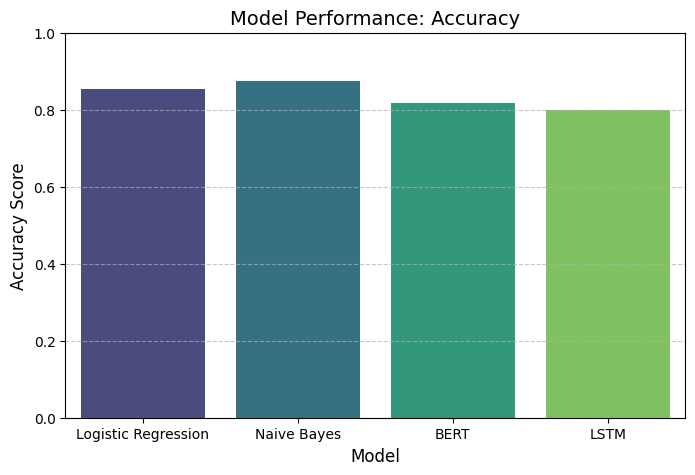

/tmp/ipython-input-3159730159.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')


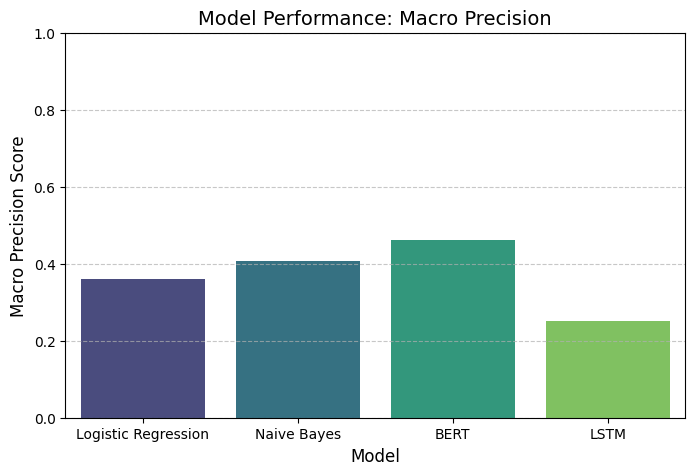

/tmp/ipython-input-3159730159.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')


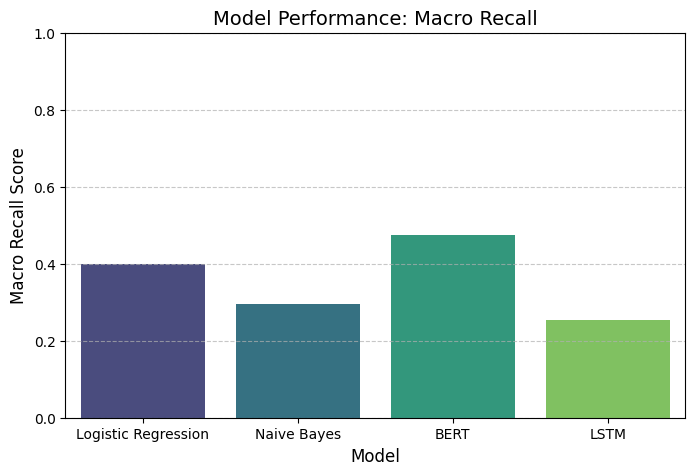

/tmp/ipython-input-3159730159.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')


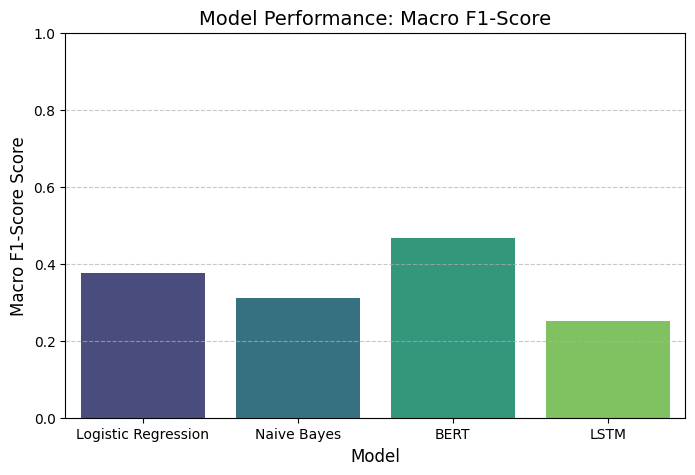

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics_to_plot = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score']

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Model', y=metric, data=metrics_df, palette='viridis')
    plt.title(f'Model Performance: {metric}', fontsize=14)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel(f'{metric} Score', fontsize=12)
    plt.ylim(0, 1) # Metrics are typically between 0 and 1
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()